# Import Libraries

In [7]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import numpy as np
import math
import os
import matplotlib
from scipy.interpolate import griddata
# Disable scientific notation
np.set_printoptions(suppress=True)
import json

# Read Image

(375, 1242, 3)


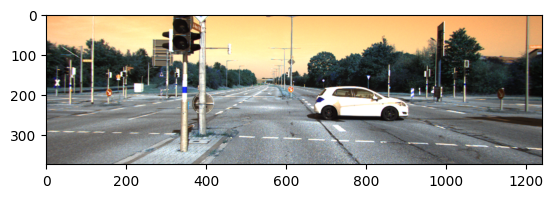

In [2]:
image = cv2.imread('L.png')
print(image.shape)
#image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
plt.imshow(image)
width, height = image.shape[1], image.shape[0]

# Load Matrices

In [3]:
velo_2_cam = open("calib_velo_to_cam.txt", "r")
cam_2_cam = open('calib_cam_to_cam.txt','r')

lines = velo_2_cam.readlines()
lines2 = cam_2_cam.readlines()

data_r = np.array(lines[1][3:-1].split(),dtype=np.float32).reshape(3,3)
data_t = np.array(lines[2][3:-1].split(),dtype=np.float32).reshape(3,1)

intrinsic_matrix = np.array(lines2[19][5:-1].split(),dtype = np.float32).reshape(3,3)
extrinsic_matrix = np.hstack((data_r, data_t))
rectification_matrix = np.array(lines2[24][11:-1].split(),dtype = np.float32).reshape(3,3)
projection_matrix = np.array(lines2[25][11:-1].split(),dtype = np.float32).reshape(-1,4)

# Create dataframe of lidar points 

In [4]:
raw_pts = np.fromfile('V.bin', dtype=np.float32).reshape(-1,4)
points = pd.DataFrame(raw_pts,columns=['X','Y','Z','I'])
points = points[points['X'] > 0]

# Apply fusion algorithm

In [5]:
image = cv2.imread('L.png')
pixel_points = []
lidar_points = []

for i in range(len(points)):
    x, y, z = points.iloc[i,:3]
    depth = math.sqrt(x**2 + y**2 + z**2)
    if 0 < depth < 25 :
        color = (255,0,0)
    elif 25 <= depth <= 50 :
        color = (0,255,0) 
    else :
        color = (0,0,255)
    
    world_pt = np.array([x,y,z]).T 
    pt_cam_coordinate = np.dot(data_r, world_pt) + data_t.T.flatten()
    rectified_pt = np.dot(rectification_matrix,pt_cam_coordinate)
    depth = round(float(rectified_pt[2]),2)
    rectified_pt = np.hstack((rectified_pt, [1]))
    projected_pt = np.dot(projection_matrix, rectified_pt)

    u , v  = int(projected_pt[0] / projected_pt[2]), int(projected_pt[1] / projected_pt[2])
    if 0 < u < 1226 :
        if 0 < v < 370 :

            lidar_points.append((u,v,depth))
            cv2.circle(image,(u,v),1,color)
    
lidar_points

[(612, 151, 32.58),
 (611, 151, 32.34),
 (609, 151, 32.15),
 (599, 155, 59.85),
 (419, 157, 76.66),
 (418, 157, 76.28),
 (416, 157, 76.27),
 (413, 157, 76.21),
 (411, 157, 76.01),
 (408, 157, 76.16),
 (402, 137, 8.88),
 (400, 137, 8.86),
 (397, 137, 8.83),
 (395, 137, 8.83),
 (392, 137, 8.81),
 (390, 137, 8.81),
 (389, 137, 8.83),
 (386, 136, 8.69),
 (384, 157, 68.24),
 (381, 157, 68.6),
 (379, 157, 67.67),
 (376, 157, 66.6),
 (374, 157, 66.45),
 (372, 157, 66.71),
 (370, 157, 65.22),
 (367, 157, 65.16),
 (365, 157, 64.93),
 (362, 157, 64.61),
 (360, 157, 64.59),
 (356, 130, 6.92),
 (355, 130, 6.87),
 (352, 130, 6.87),
 (349, 130, 6.86),
 (347, 129, 6.69),
 (344, 130, 6.85),
 (343, 157, 63.63),
 (342, 157, 63.72),
 (334, 155, 35.03),
 (331, 155, 34.85),
 (329, 155, 34.75),
 (326, 155, 34.52),
 (325, 157, 63.41),
 (322, 157, 63.04),
 (319, 155, 35.19),
 (317, 155, 35.23),
 (314, 155, 35.29),
 (312, 157, 61.97),
 (307, 154, 32.58),
 (305, 154, 32.55),
 (296, 154, 31.96),
 (294, 154, 31.8

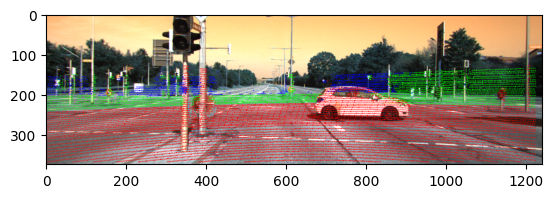

In [6]:
plt.imshow(image)
#cv2.imwrite('Fused.png',image)

In [7]:
lidar_points_np = [(v,u,depth) for (u,v,depth) in lidar_points ]
sparse_depth_map = np.zeros(shape = (height,width))
for i,u,depth in lidar_points_np:
    sparse_depth_map[i,u] = depth

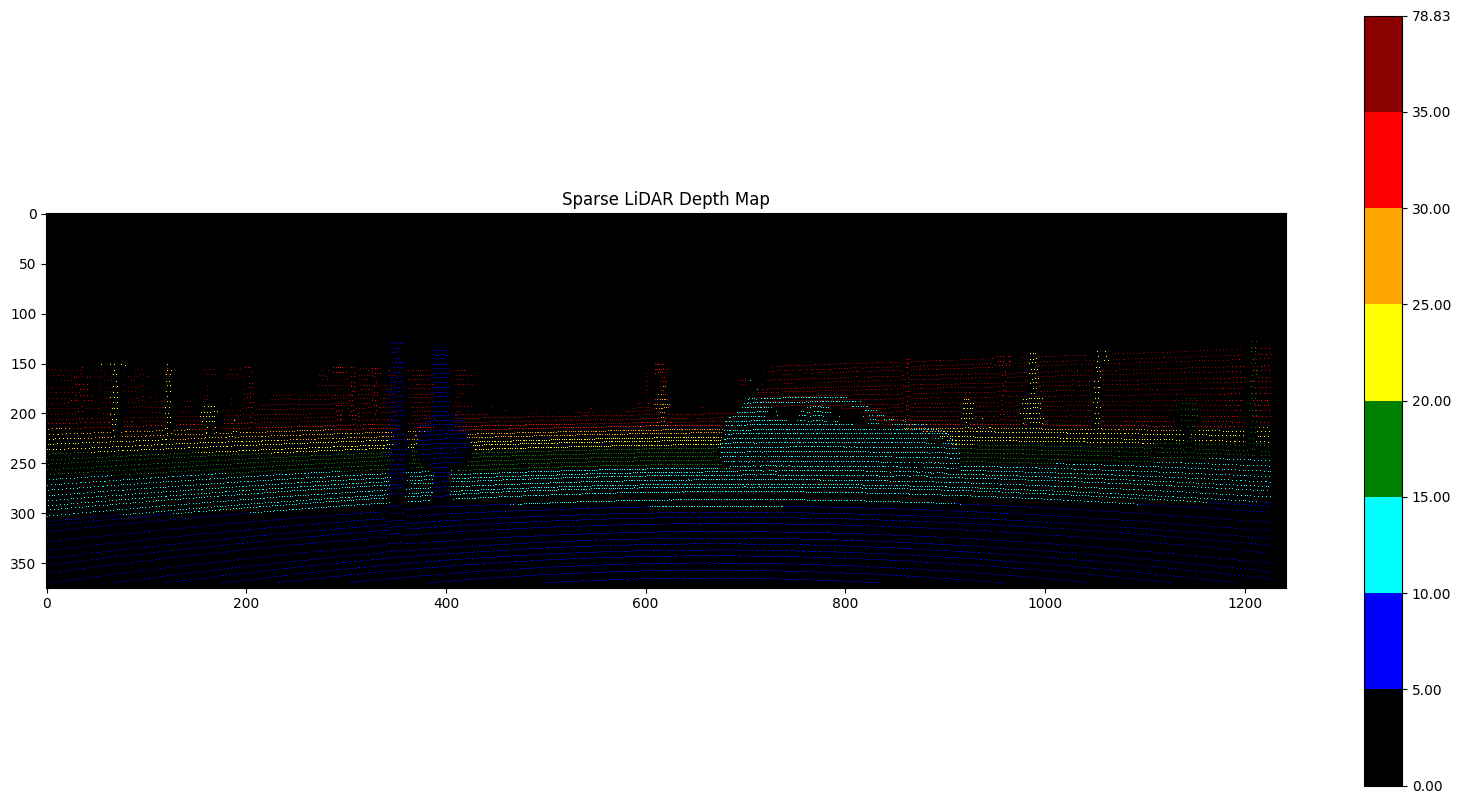

In [8]:
valid_depths = sparse_depth_map[sparse_depth_map > 0]
min_depth , max_depth = valid_depths.min(), valid_depths.max()
bins = [0, 5, 10, 15, 20, 25, 30, 35, np.max(sparse_depth_map)]  # Adjust as needed
colors = ["black", "blue", 'cyan', "green", "yellow", "orange", "red", "darkred"]  # Custom colors

# Create a colormap from the defined colors
cmap = matplotlib.colors.ListedColormap(colors)

# Use BoundaryNorm to ensure bins match colors, but no normalization is applied
norm = matplotlib.colors.BoundaryNorm(bins, cmap.N)
plt.figure(figsize=(20,10))
plt.imshow(sparse_depth_map, cmap=cmap, norm=norm, interpolation='nearest')
plt.title("Sparse LiDAR Depth Map")
plt.colorbar()
plt.savefig('Sparse Point Clouds.png')
plt.show()

#

# FoundationStereo

In [28]:
fs_depths = np.load('test_outputs/depth_meter.npy')
fs_depths.shape, image.shape

((375, 1242), (375, 1242, 3))

In [10]:
lidar_points_np = [(v,u,z) for (u,v,z) in lidar_points]

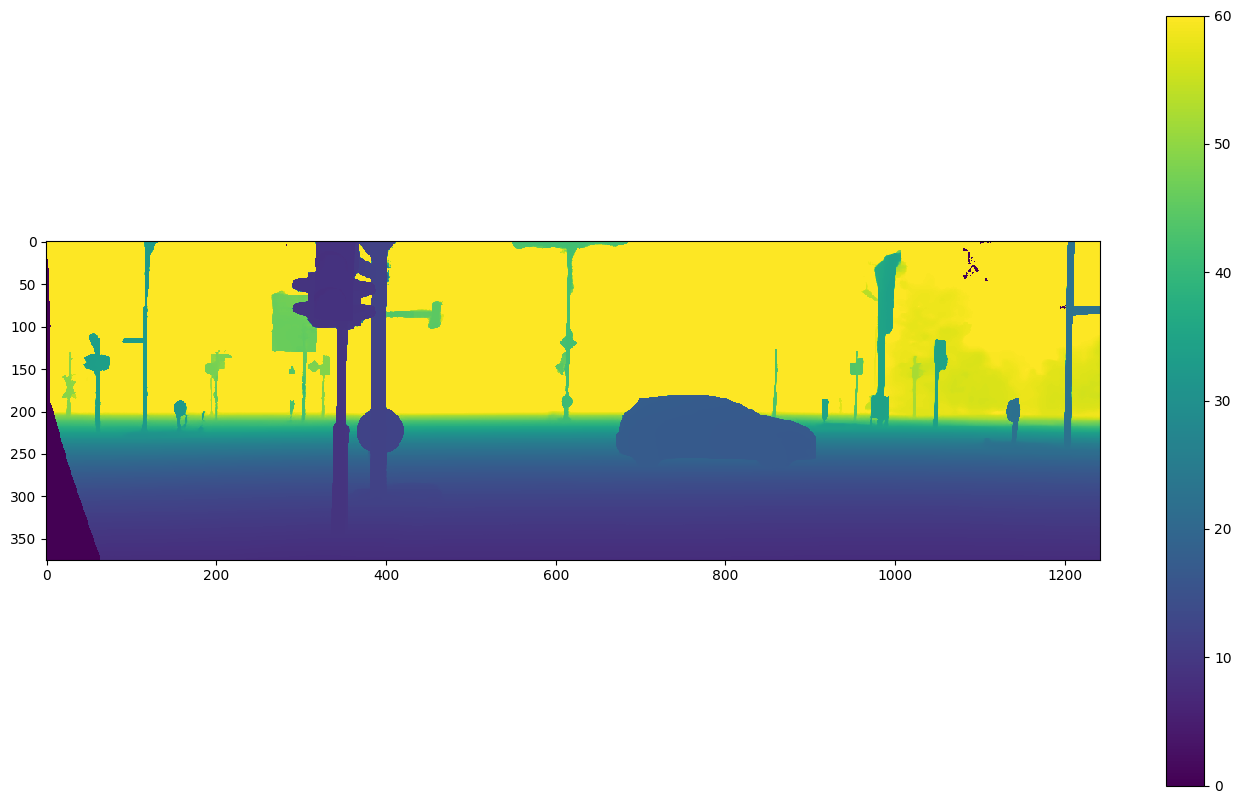

In [11]:
my_disp = np.load('disparity.npy')
my_depth =( 959.7910 * 0.5327 ) / my_disp
plt.figure(figsize=(17,10))
plt.imshow(fs_depths, vmin=0,vmax=60, interpolation='nearest')
plt.colorbar()

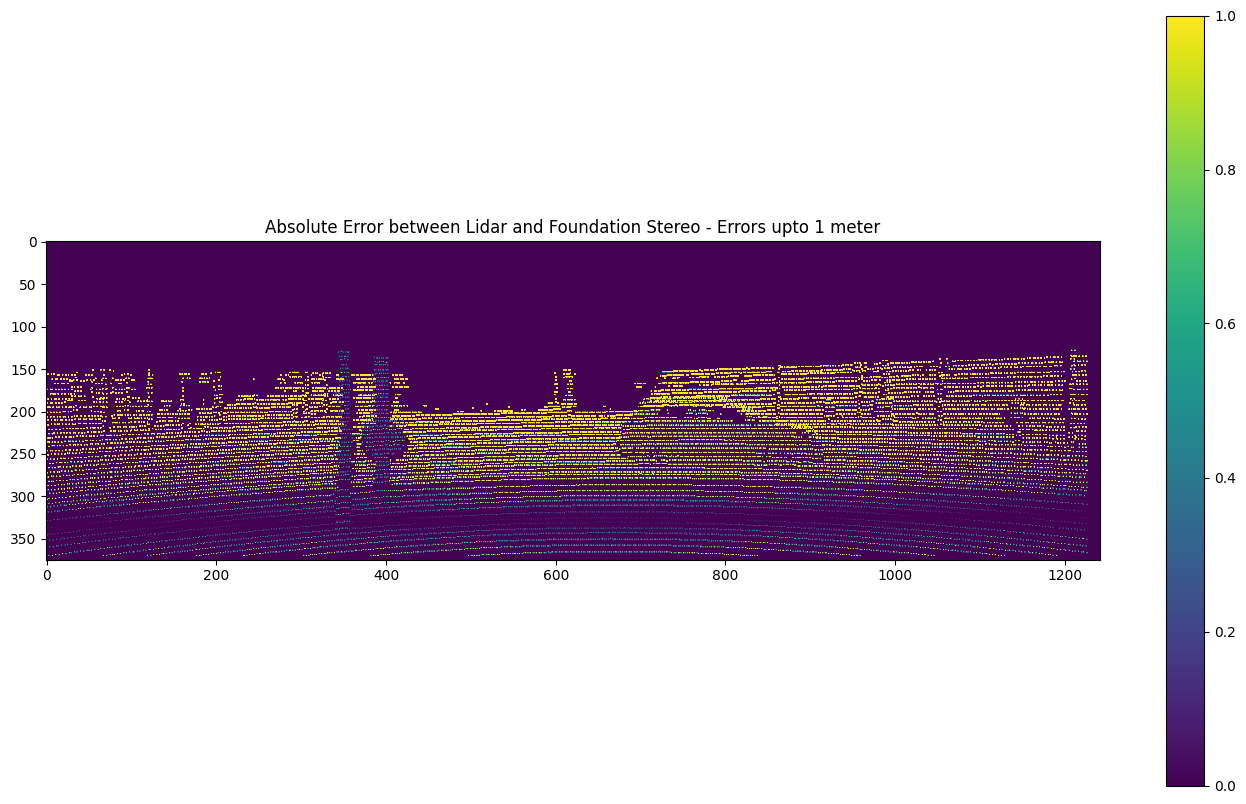

In [12]:
difference_map = np.zeros(shape = (375,1242),dtype=np.float32)
fd_points = []
for i in range(375):
    for j in range(1242):
        d = fs_depths[i,j]
        if 0 <= d and d <= 60 :
            fd_points.append(d)
            
np.mean(fd_points) - np.mean([z for (x,y,z) in lidar_points]) 

for x,y,z in lidar_points_np:
    difference_map[x,y] = abs(fs_depths[i,j] - z)

plt.figure(figsize=(17,10))
plt.title('Absolute Error between Lidar and Foundation Stereo - Errors upto 1 meter')
plt.imshow(difference_map, vmin=0,vmax=1)
plt.colorbar()

plt.savefig('Error between Lidar and FS.png')


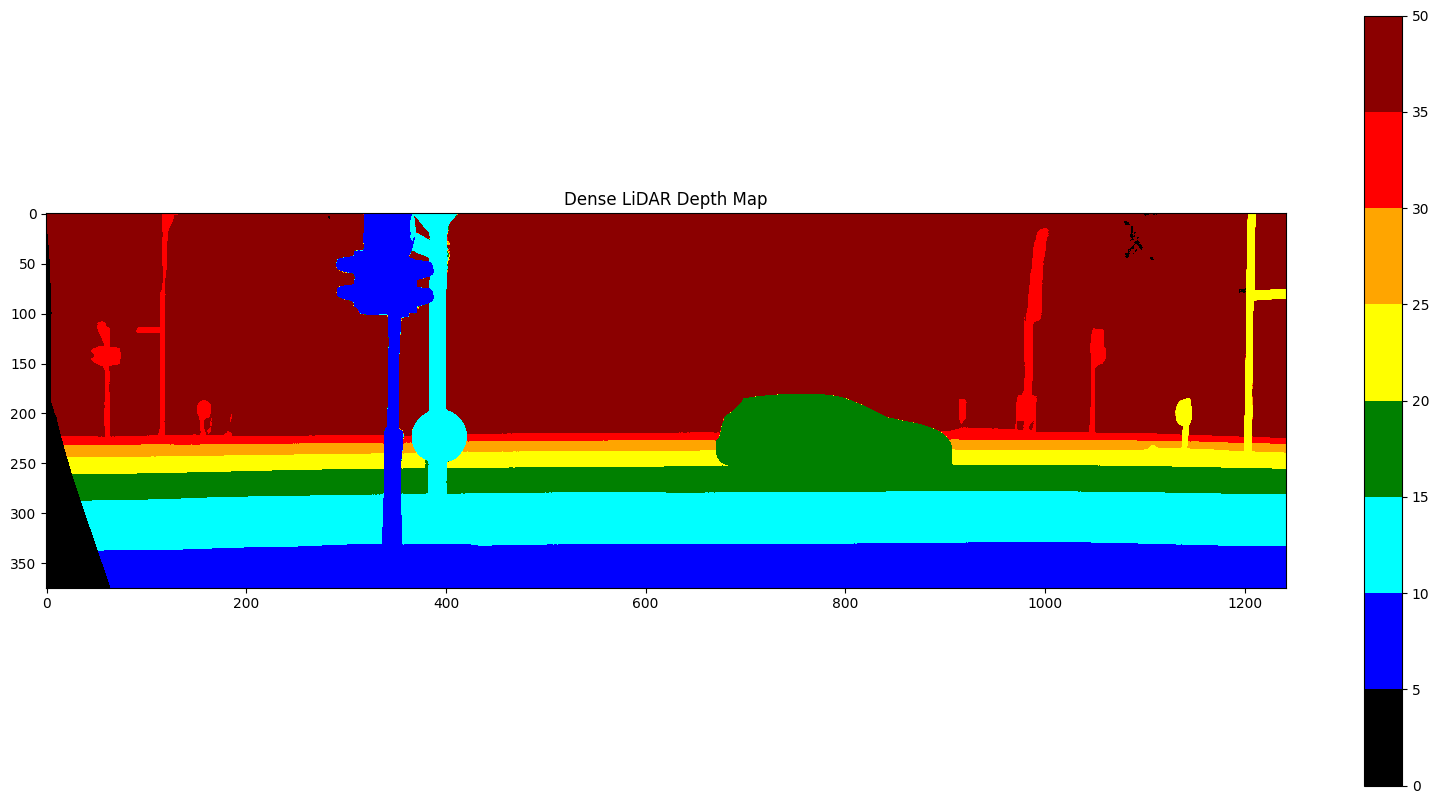

In [84]:
bins = [0, 5, 10, 15, 20, 25, 30, 35, 50]  # Adjust as needed
colors = ["black", "blue", 'cyan', "green", "yellow", "orange", "red", "darkred"]  # Custom colors

# Create a colormap from the defined colors
cmap = matplotlib.colors.ListedColormap(colors)

# Use BoundaryNorm to ensure bins match colors, but no normalization is applied
norm = matplotlib.colors.BoundaryNorm(bins, cmap.N)
plt.figure(figsize=(20,10))
plt.imshow(fs_depths, norm = norm,cmap=cmap, interpolation='nearest')
#plt.imshow(fs_depths, cmap=cmap)

plt.title("Dense LiDAR Depth Map")
plt.colorbar()
plt.savefig('My Depth Map.png')
plt.show()

In [31]:
depths = []
for x,y,z in lidar_points_np :
        predicted_depth = round(float(fs_depths[x,y]),2)
        gt_depth = z
        depths.append((x,y,z,predicted_depth))

predicted_depths = [x[3] for x in depths]
gt_depths = [x[2] for x in depths]
errors = [abs(x[2] - x[3]) for x in depths]

## With K Matrix

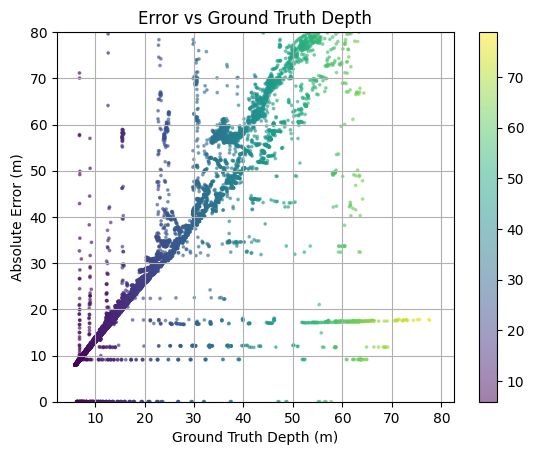

In [22]:
import matplotlib.pyplot as plt

plt.scatter(gt_depths, predicted_depths, s=3, alpha=0.5,c = gt_depths)
plt.xlabel("Ground Truth Depth (m)")
plt.ylabel("Absolute Error (m)")
plt.title("Error vs Ground Truth Depth")
plt.ylim(0, 80)
plt.colorbar()
plt.grid(True)
plt.show()

## With Projection Matrix

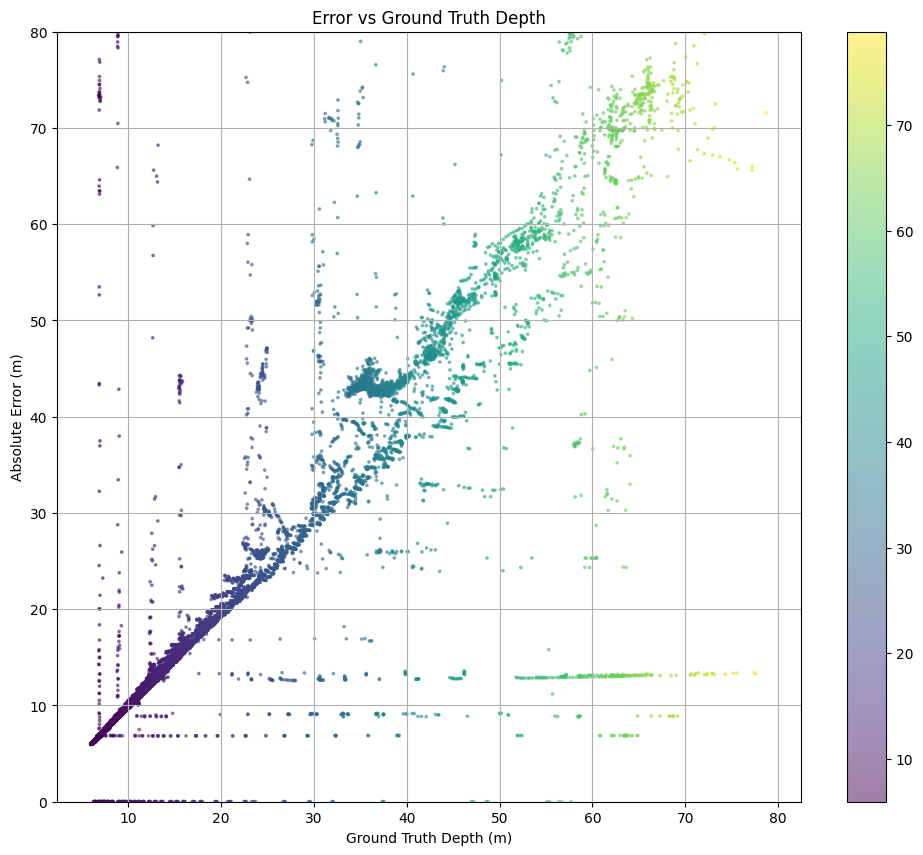

In [37]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,10))
plt.scatter(gt_depths, predicted_depths, s=3, alpha=0.5,c = gt_depths)
plt.xlabel("Ground Truth Depth (m)")
plt.ylabel("Absolute Error (m)")
plt.title("Error vs Ground Truth Depth")
plt.ylim(0, 80)
plt.colorbar()
plt.grid(True)
plt.savefig('Plot of GT Truth vs FS Depth.png')
plt.show()

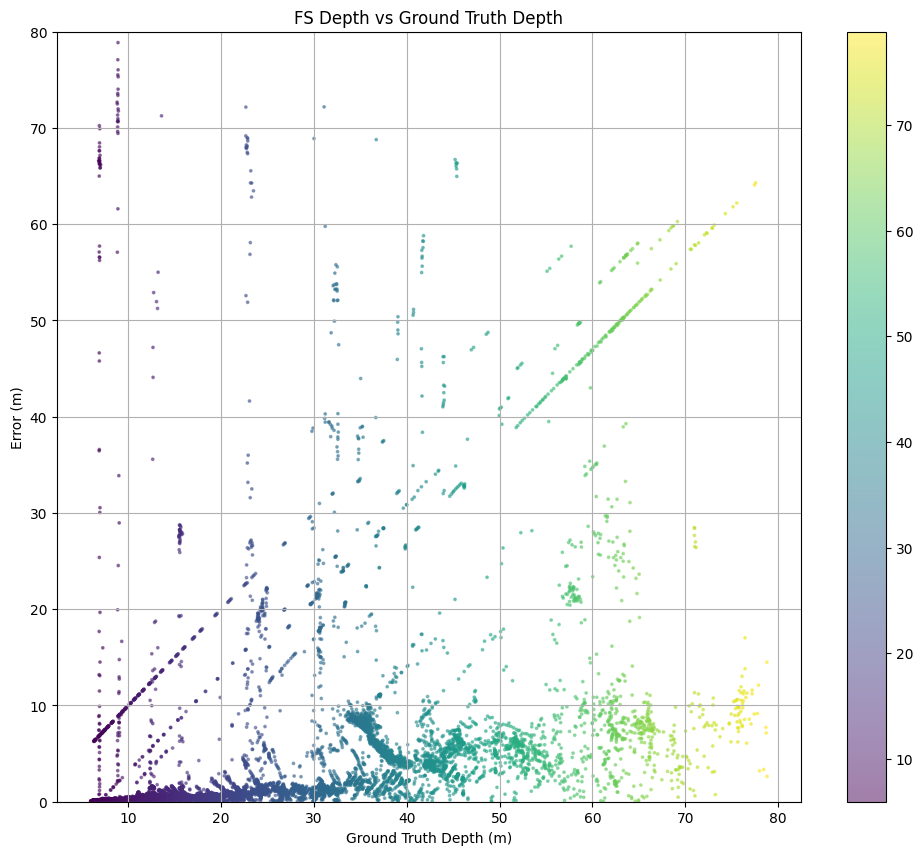

In [40]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,10))
plt.scatter(gt_depths, errors, s=3, alpha=0.5,c = gt_depths)
plt.xlabel("Ground Truth Depth (m)")
plt.ylabel("Error (m)")
plt.title("FS Depth vs Ground Truth Depth")
plt.ylim(0, 80)
plt.colorbar()
plt.grid(True)
plt.savefig('Plot of GT Truth vs Error.png')
plt.show()

In [33]:
np.median(gt_depths), np.median(predicted_depths)

(np.float64(12.91), np.float64(12.87))

In [12]:
with open("sensor_rig.json", "r", encoding="latin1") as f:
    data = f.read()   

In [ ]:
jig_lines = jig_info.readlines()
data = json.load

UnicodeDecodeError: 'charmap' codec can't decode byte 0x8f in position 62: character maps to <undefined>

In [13]:
data

'PEBF\x11ÐZÍ\x01\x00\x00\x00\x00\x00\x00\x00\x01\x00\x00\x00\x17ªº>\x9fTçÇÁ*2Ìc\x0fM\x06»\x80eÇÛ\x85\x92¹D½AØ\tf~\x0cÚ\x01-D^\x8e\x0e;\x95V\x8f´}/Hè§ê\x97"5Ëë¶ð\x8c\x1aüúy=ìgÜã¹^\x14\x88\x98\x8bîö¡3Ç\x1cÔ\x84}d\x9b\x14|£O·\x9a0²\n+/ç\x08æ\x0bÖ\x9a\x11\x1bÄ\x88\x13\xa0x-ú:\x94¸ìWççc5»dr-©x©k#qHªàñ×Ðößáâ\x8axÕ´Ã\x90¤ø\x00\x90ÚÝ!Ø³_\x89XåðN¼\x17øÐÝ\x04\x06\x92ò\x980}+\t\x85Uq°\x8a\x81\\\x07T?\x85nÚqwðµ\x7fële=Û¬\x10\x1e}\x1au8®C\x98@ÁÀð\n\x0bÈÊ\x85éÊ\x8e\x1fI\x96ªw\x00No\x8b\x9eHPaß\x8a-ð²Q\x8b\x02:kÔs~R\x7f´iØ\x1biké\'(º\x1a ý\x81\x7fÙÇÔ\x01<õa\x1d\\\x13ä°³ÊÂ\x99\x91¨L\x83Té\tjm2Ö\x9cu²;ü\t4\x88Yé´A:Jèç(\x83$:ÒÑ´þS\n\x1ae¢\x85\x84êb\x13Ç\x9d°G^\x88ò\x97Xþ]\x82\x18\x9eb·Ö^\x0fÌçÒ_bÜ¬øýf\x08\x19ògû\x87h\x9b:\x83û÷\x84¹RûHÔÊ>r\x80èÊ5|\x88»®<æ½ \x87ªt\x13ø]X{î¶pæ\x83æÖÇ9$BB\x19\x10=\x01\x1bÅR\x9eàø·\\\x88«Þä\x0c\x8f½\nÝv%÷«Ö\x97uª\t:\x94§Åëö.W!|þ\xadãÎ²\x90\x82,\x1b³\x0f\x0fzz ³q\x9aHÁùá\x10êG\x1d(¥M\x8b°¿\x847!Ê\x14pò.Eïé\x05åÁ±å?îÂ¬¶òáÒ(ßêI\x1b\x90Æ÷¤2,L\x94/þ\x8aðø"\x88ýSPé«[\x01\x9d$\x87